<a href="https://colab.research.google.com/github/dagmaros27/AIMS_Notebooks/blob/main/interpretations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss

# Linear regression

### Data

In [2]:
np.random.seed(42)

cov = np.array([
    [1.0, 0.2, 0.0,   0.0],
    [0.2, 1.0, 0.0,   0.0],
    [0.0,  0.0, 1.0,   0.0],
    [0.0,  0.0, 0.0,  1.0],  # feature_3 much higher variance
])
mean = np.zeros(4)
X = np.random.multivariate_normal(mean, cov, size=1500)
feature_names = ["feature_0", "feature_1", "feature_2", "feature_3"]
df = pd.DataFrame(X, columns=feature_names)

true_coefs = [3, 3, -2, 0.2]
def target_fn(x0, x1, x2, x3):
    return true_coefs[0]*(x0 + x1) + true_coefs[2]*x2 + true_coefs[3]*x3

noise = np.random.normal(0, 3.0, size=len(df))
df["target"] = target_fn(df["feature_0"], df["feature_1"], df["feature_2"], df["feature_3"]) + noise

X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df.head()

,feature_0,feature_1,feature_2,feature_3,target
0,-1.348002,0.578496,0.647689,-0.138264,-6.973793
1,-0.303994,0.666743,1.579213,-0.234137,-4.009799
2,0.658207,0.069100,-0.463418,0.542560,0.391087
3,0.168199,-0.543045,-1.724918,-1.913280,0.298653
4,1.677755,-0.108684,-0.908024,0.314247,5.943660


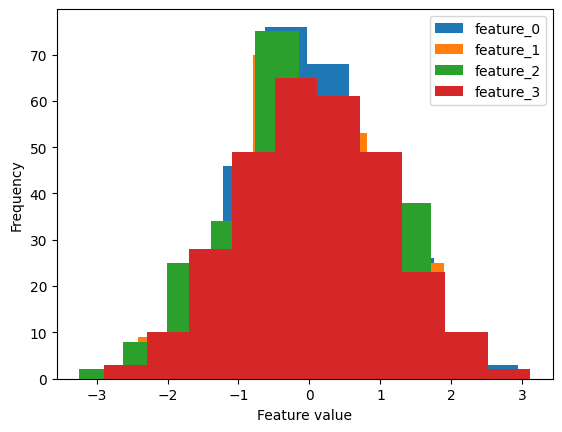

In [3]:
for feat in feature_names:
    plt.hist(X_test[feat], label=feat)
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Feature value")
plt.show()

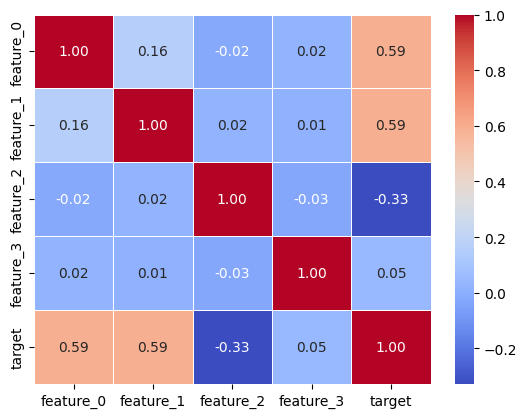

In [4]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

### Linear regression model

Coefficients: [ 2.94292694  2.97932683 -1.89645557  0.1747756 ]
Intercept: -0.0009221085383866109
Test MSE: 9.986653723291417


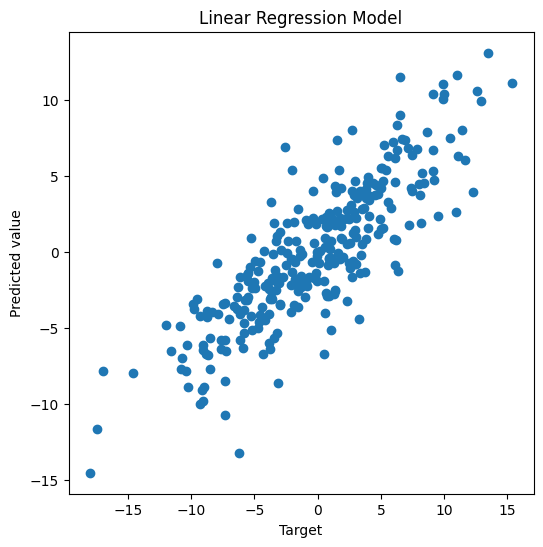

In [5]:
# Fit linear regression
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coefs = ols.coef_

# Predict
y_pred = ols.predict(X_test)

# Performance
mse = mean_squared_error(y_test, y_pred)

print("Coefficients:", ols.coef_)
print("Intercept:", ols.intercept_)
print("Test MSE:", mse)

# Plot y_test vs y_pred
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Target")
plt.ylabel("Predicted value")
plt.title("Linear Regression Model")
plt.show()

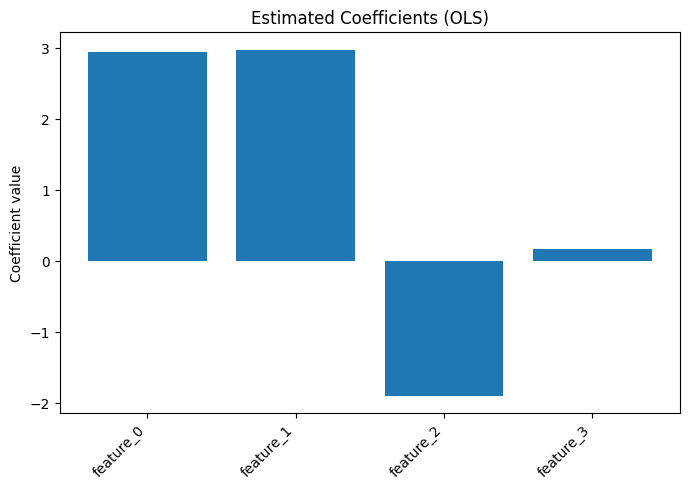

Coefficients: [ 2.94292694  2.97932683 -1.89645557  0.1747756 ]


In [6]:
# Plot coefficients
x_pos = np.arange(len(feature_names))
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(x_pos, ols_coefs)
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha="right")
ax.set_ylabel("Coefficient value")
ax.set_title("Estimated Coefficients (OLS)")
plt.tight_layout()
plt.show()
print("Coefficients:", ols_coefs)

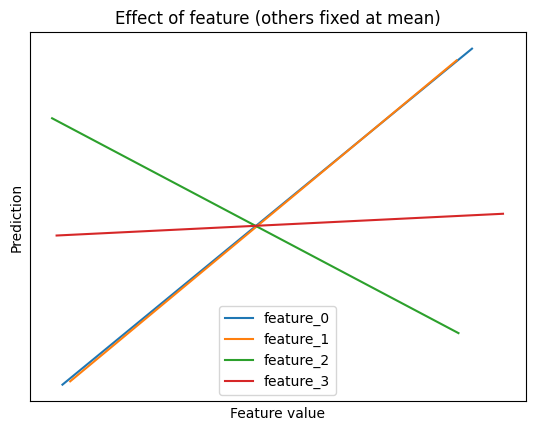

In [7]:
# Effect-of-feature plot (others fixed at mean)

for feat in feature_names:
    baseline = X_train.mean().to_frame().T  # single-row DataFrame
    x_vals = np.linspace(df[feat].min(), df[feat].max(), 200)

    pred_df = pd.concat([baseline]*len(x_vals), ignore_index=True)
    pred_df[feat] = x_vals  # override only the chosen feature
    preds = ols.predict(pred_df)
    plt.plot(x_vals, preds, label=feat)

plt.ylabel("Prediction")
plt.xlabel("Feature value")
plt.title(f"Effect of feature (others fixed at mean)")
plt.legend()
#plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.show()

[3.487754]
[3.4566194]
[-1.98948201]
[0.35456995]


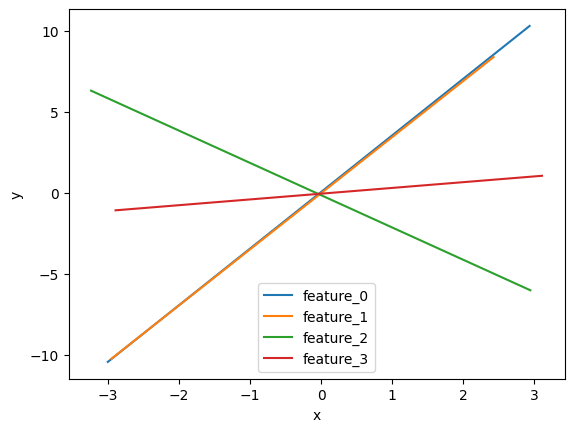

In [8]:
# Single variable regression
for feat in feature_names:
    _ols = LinearRegression()
    _X_train = X_train[feat].to_numpy().reshape(-1, 1)
    _X_test = X_test[feat].to_numpy().reshape(-1, 1)
    _ols.fit(_X_train, y_train.to_numpy())
    y_pred = _ols.predict(_X_test)

    plt.plot(np.sort(_X_test.flatten()), _ols.predict(np.sort(_X_test, axis=0)), label=feat)
    print(_ols.coef_)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

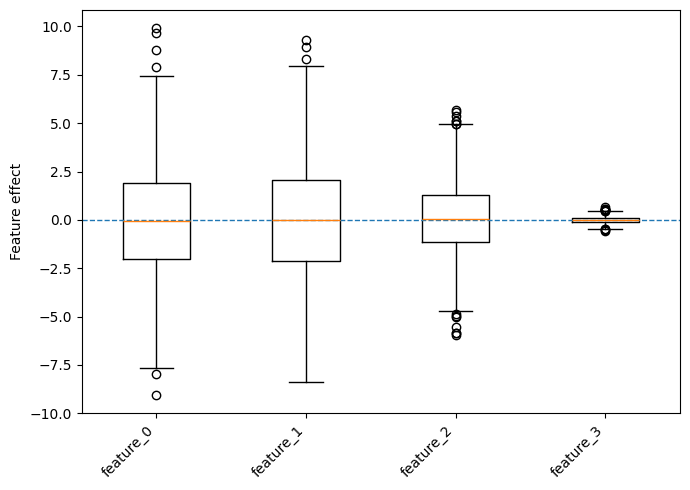

In [9]:
# Effect plot
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coefs = ols.coef_
effects = {}
for i, feat in enumerate(feature_names):
    _effects = X_train[feat].to_numpy()*ols_coefs[i]
    effects[feat] = _effects

fig, ax = plt.subplots(figsize=(7,5))
ax.boxplot([effects[_key] for _key in effects.keys()], tick_labels=feature_names)#, vert=True)
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_ylabel("Feature effect")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Different feature scales and centering

In [10]:
np.random.seed(42)

cov = np.array([
    [30.0, 0.2, 0.0,   0.0],
    [0.2, 1.0, 0.0,   0.0],
    [0.0,  0.0, 1.0,   0.0],
    [0.0,  0.0, 0.0,  1.0],
])
mean = np.array([30,3,2,1])

X = np.random.multivariate_normal(mean, cov, size=1500)
feature_names = ["feature_0", "feature_1", "feature_2", "feature_3"]
df = pd.DataFrame(X, columns=feature_names)

true_coefs = [3, 3, -2, 0.2]
def target_fn(x0, x1, x2, x3):
    return true_coefs[0]*(x0 + x1) + true_coefs[2]*x2 + true_coefs[3]*x3

noise = np.random.normal(0, 3.0, size=len(df))
df["target"] = target_fn(df["feature_0"], df["feature_1"], df["feature_2"], df["feature_3"]) + noise

X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

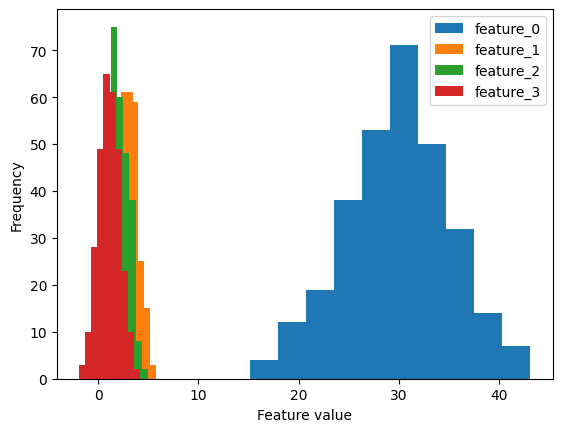

In [11]:
for feat in feature_names:
    plt.hist(X_test[feat], label=feat)
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Feature value")
plt.show()

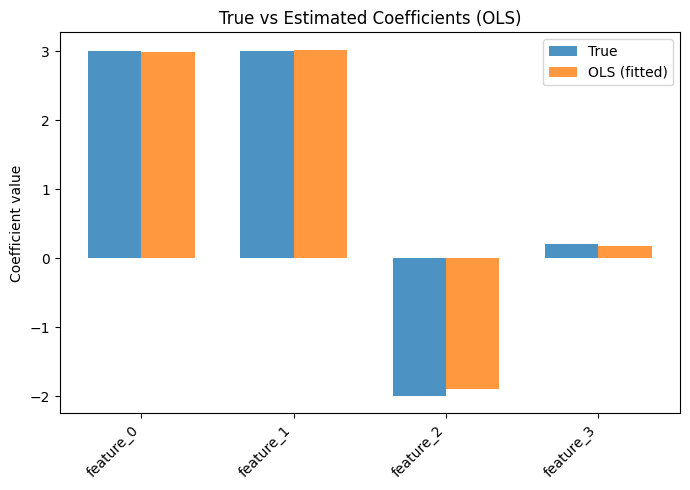

In [13]:
# True vs OLS coefficients
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coefs = ols.coef_

x_pos = np.arange(len(feature_names))
width = 0.35
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(x_pos - width/2, true_coefs, width, label="True", alpha=0.8)
ax.bar(x_pos + width/2, ols_coefs, width, label="OLS (fitted)", alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha="right")
ax.set_ylabel("Coefficient value")
ax.set_title("True vs Estimated Coefficients (OLS)")
ax.legend()
plt.tight_layout()
plt.show()

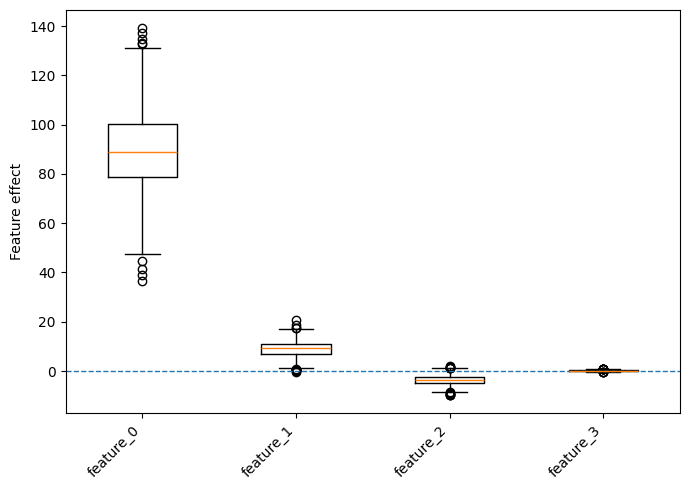

In [14]:
# Effect plot
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coefs = ols.coef_
effects = {}
for i, feat in enumerate(feature_names):
    _effects = X_train[feat].to_numpy()*ols_coefs[i]
    effects[feat] = _effects

fig, ax = plt.subplots(figsize=(7,5))
ax.boxplot([effects[_key] for _key in effects.keys()], tick_labels=feature_names)#, vert=True)
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_ylabel("Feature effect")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Correlated features

In [15]:
np.random.seed(42)

cov = np.array([
    [1.0, 0.99, 0.0,   0.0],
    [0.99, 1.0, 0.0,   0.0],
    [0.0,  0.0, 1.0,   0.0],
    [0.0,  0.0, 0.0,  1.0],
])
mean = np.array([1,2,3,4])
X = np.random.multivariate_normal(mean, cov, size=1500)
feature_names = ["feature_0", "feature_1", "feature_2", "feature_3"]
df = pd.DataFrame(X, columns=feature_names)

true_coefs = [3, 3, -2, 0.2]
def target_fn(x0, x1, x2, x3):
    return true_coefs[0]*(x0 + x1) + true_coefs[2]*x2 + true_coefs[3]*x3

noise = np.random.normal(0, 3.0, size=len(df))
df["target"] = target_fn(df["feature_0"], df["feature_1"], df["feature_2"], df["feature_3"]) + noise

X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

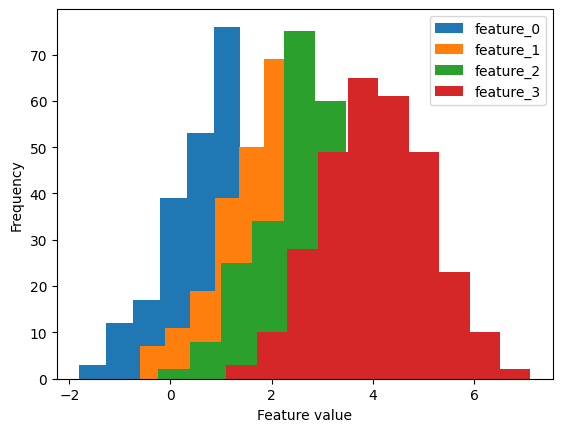

In [16]:
for feat in feature_names:
    plt.hist(X_test[feat], label=feat)
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Feature value")
plt.show()

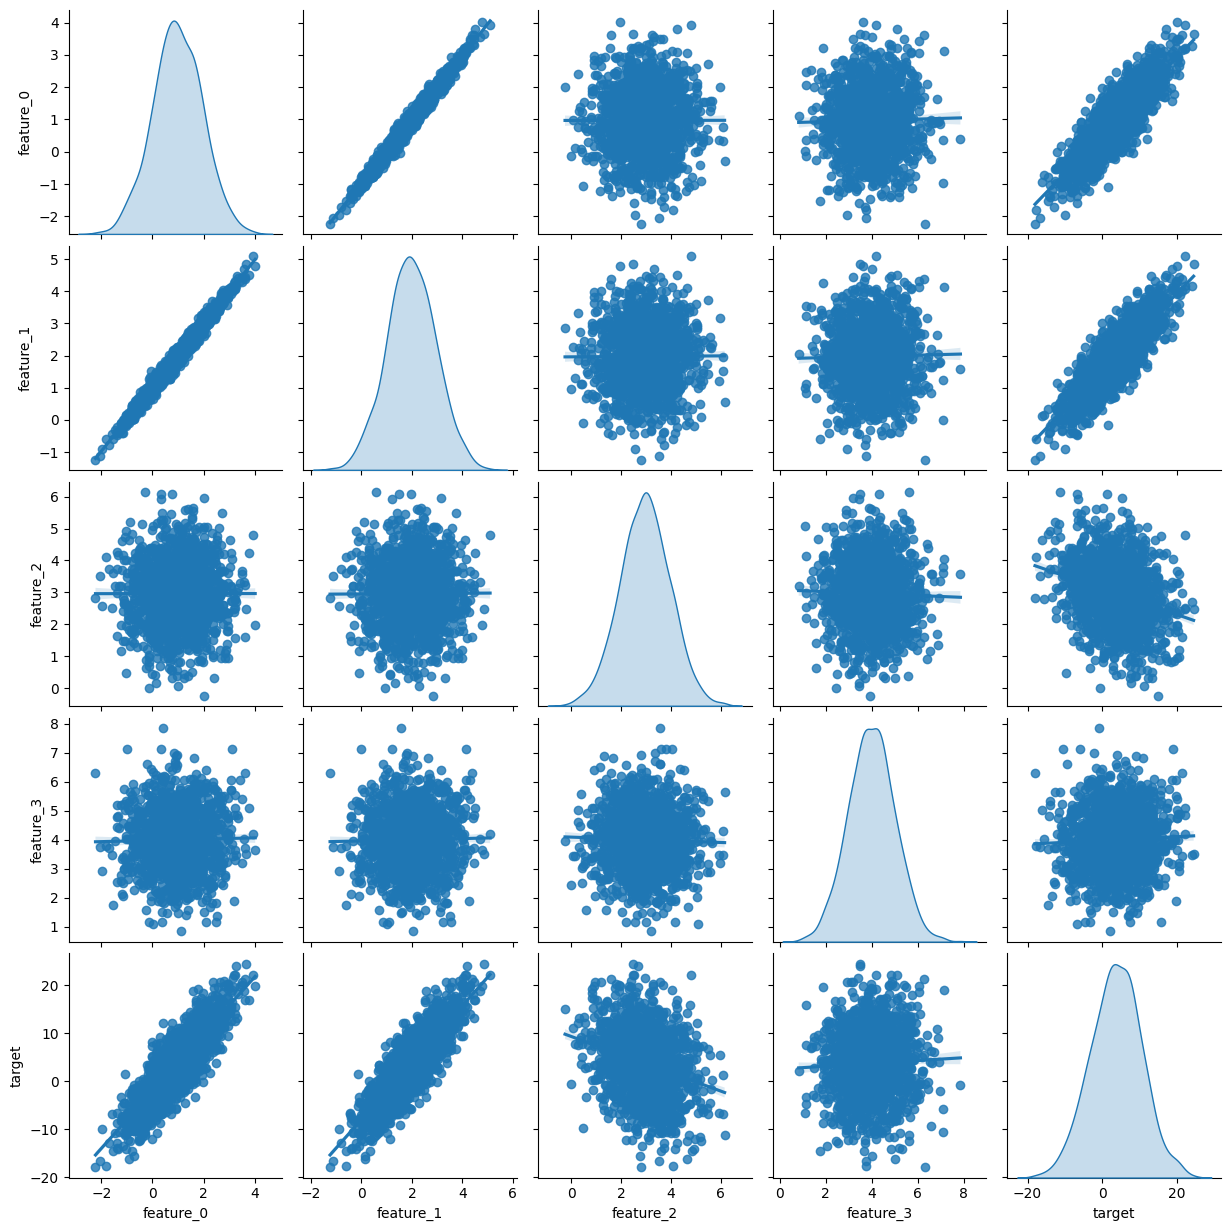

In [17]:
sns.pairplot(df, kind="reg", diag_kind="kde")
plt.show()
#df.corr()

Coefficients: [ 2.80702817  3.13259873 -1.89645557  0.1747756 ]
Intercept: -0.2828834292225877
Test MSE: 9.98665372329142


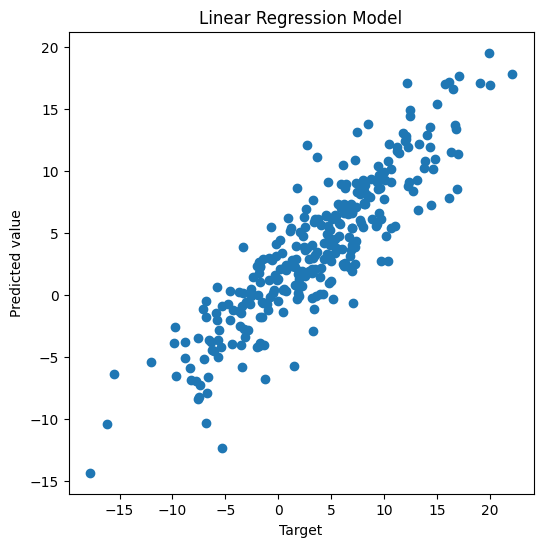

In [18]:
# Fit linear regression
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coefs = ols.coef_

# Predict
y_pred = ols.predict(X_test)

# Performance
mse = mean_squared_error(y_test, y_pred)

print("Coefficients:", ols.coef_)
print("Intercept:", ols.intercept_)
print("Test MSE:", mse)

# Plot y_test vs y_pred
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Target")
plt.ylabel("Predicted value")
plt.title("Linear Regression Model")
plt.show()

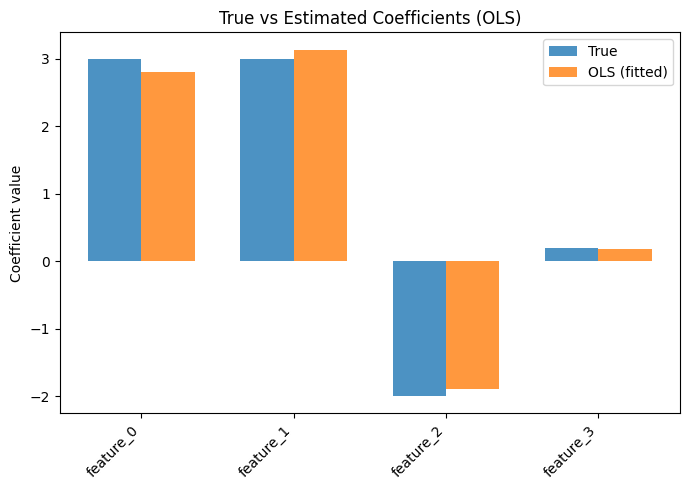

In [19]:
# 2) True vs OLS coefficients
x_pos = np.arange(len(feature_names))
width = 0.35
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(x_pos - width/2, true_coefs, width, label="True", alpha=0.8)
ax.bar(x_pos + width/2, ols_coefs, width, label="OLS (fitted)", alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha="right")
ax.set_ylabel("Coefficient value")
ax.set_title("True vs Estimated Coefficients (OLS)")
ax.legend()
plt.tight_layout()
plt.show()

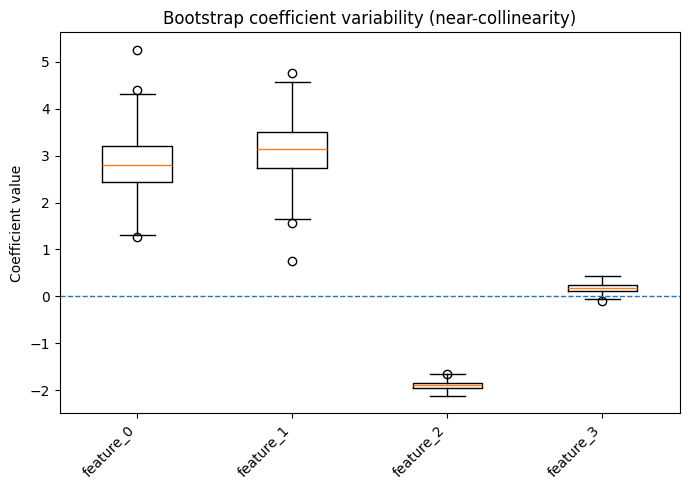

In [20]:
# --- 3) Bootstrap coefficient variability ---
B = 300
boot = []
for _ in range(B):
    X_b, y_b = resample(X_train, y_train, replace=True)
    m = LinearRegression().fit(X_b, y_b)
    boot.append(m.coef_)
boot = np.array(boot)

fig, ax = plt.subplots(figsize=(7,5))
ax.boxplot([boot[:, i] for i in range(len(feature_names))], tick_labels=feature_names, vert=True)
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("Bootstrap coefficient variability (near-collinearity)")
ax.set_ylabel("Coefficient value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Decision trees

In [21]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.datasets import fetch_openml #, load_diabetes
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Local interpretability

### Bike demand data

In [22]:
def encode_string_features_oh(df):
    # Select categorical (string/object) columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    # Keep numerical columns as is
    num_cols = df.select_dtypes(exclude=["object", "category"]).columns

    # Fit encoder
    enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded = enc.fit_transform(df[cat_cols])

    # Build encoded dataframe
    encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(cat_cols), index=df.index)

    # Concatenate
    final_df = pd.concat([df[num_cols], encoded_df], axis=1)

    return final_df, enc

def encode_string_features(df):
    df = df.copy()
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders

In [23]:
bike = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike.frame
features = df.columns
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981,61


In [24]:
df_enc, enc = encode_string_features(df)
df_enc

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,1,0,1,0,0,6,0,0,9.84,14.395,0.81,0.0000,16
1,1,0,1,1,0,6,0,0,9.02,13.635,0.80,0.0000,40
2,1,0,1,2,0,6,0,0,9.02,13.635,0.80,0.0000,32
3,1,0,1,3,0,6,0,0,9.84,14.395,0.75,0.0000,13
4,1,0,1,4,0,6,0,0,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,10.66,12.880,0.60,11.0014,119
17375,1,1,12,20,0,1,1,2,10.66,12.880,0.60,11.0014,89
17376,1,1,12,21,0,1,1,0,10.66,12.880,0.60,11.0014,90
17377,1,1,12,22,0,1,1,0,10.66,13.635,0.56,8.9981,61


In [25]:
for col, le in enc.items():
    mapping = {cls: idx for idx, cls in enumerate(le.classes_)}
    print(col, mapping)

season {'fall': 0, 'spring': 1, 'summer': 2, 'winter': 3}
holiday {'False': 0, 'True': 1}
workingday {'False': 0, 'True': 1}
weather {'clear': 0, 'heavy_rain': 1, 'misty': 2, 'rain': 3}


In [26]:
X = df_enc.drop(columns=["count"])
y = df_enc["count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tiny tree

Nodes in decision tree: 7


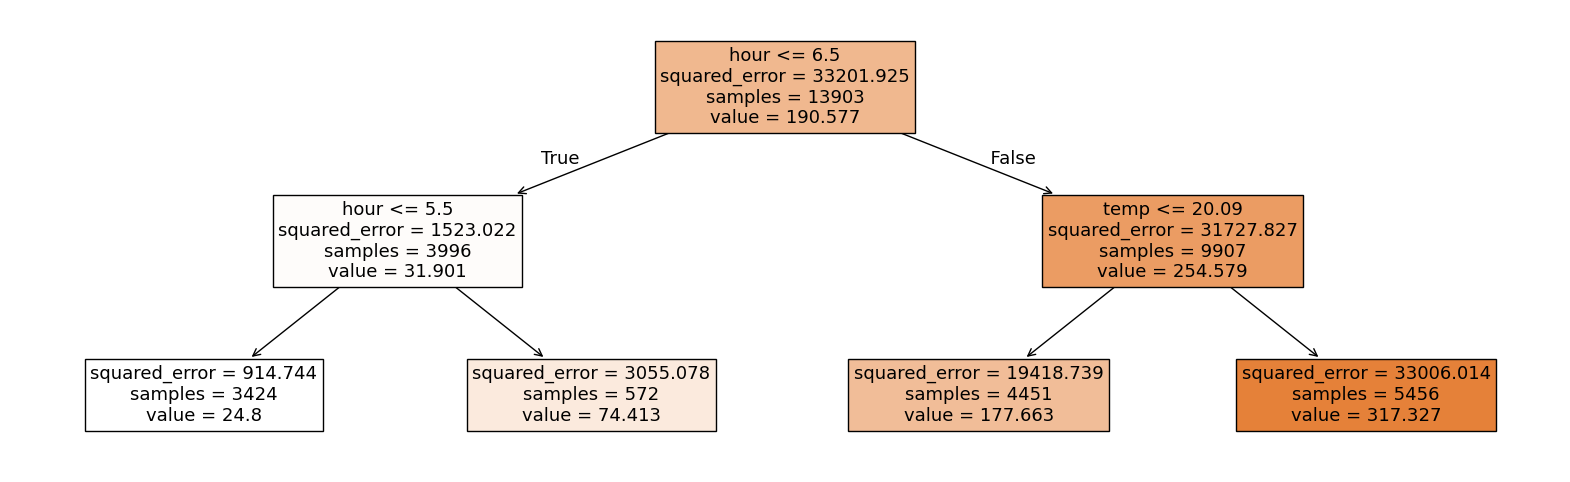

In [27]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(X_train, y_train);
print("Nodes in decision tree:", model.tree_.node_count)
plt.figure(figsize=(20,6))
plot_tree(model, filled=True, feature_names=features, fontsize=13)
plt.savefig("tree_depth_2.pdf", format='pdf')

In [28]:
X_test.sample(random_state=2)

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
8201,3,0,12,9,0,2,1,0,10.66,12.88,0.6,11.0014


In [29]:
model.predict(X_test.loc[[8201]]).item()

177.6634464165356

### Medium tree

Nodes in decision tree: 505


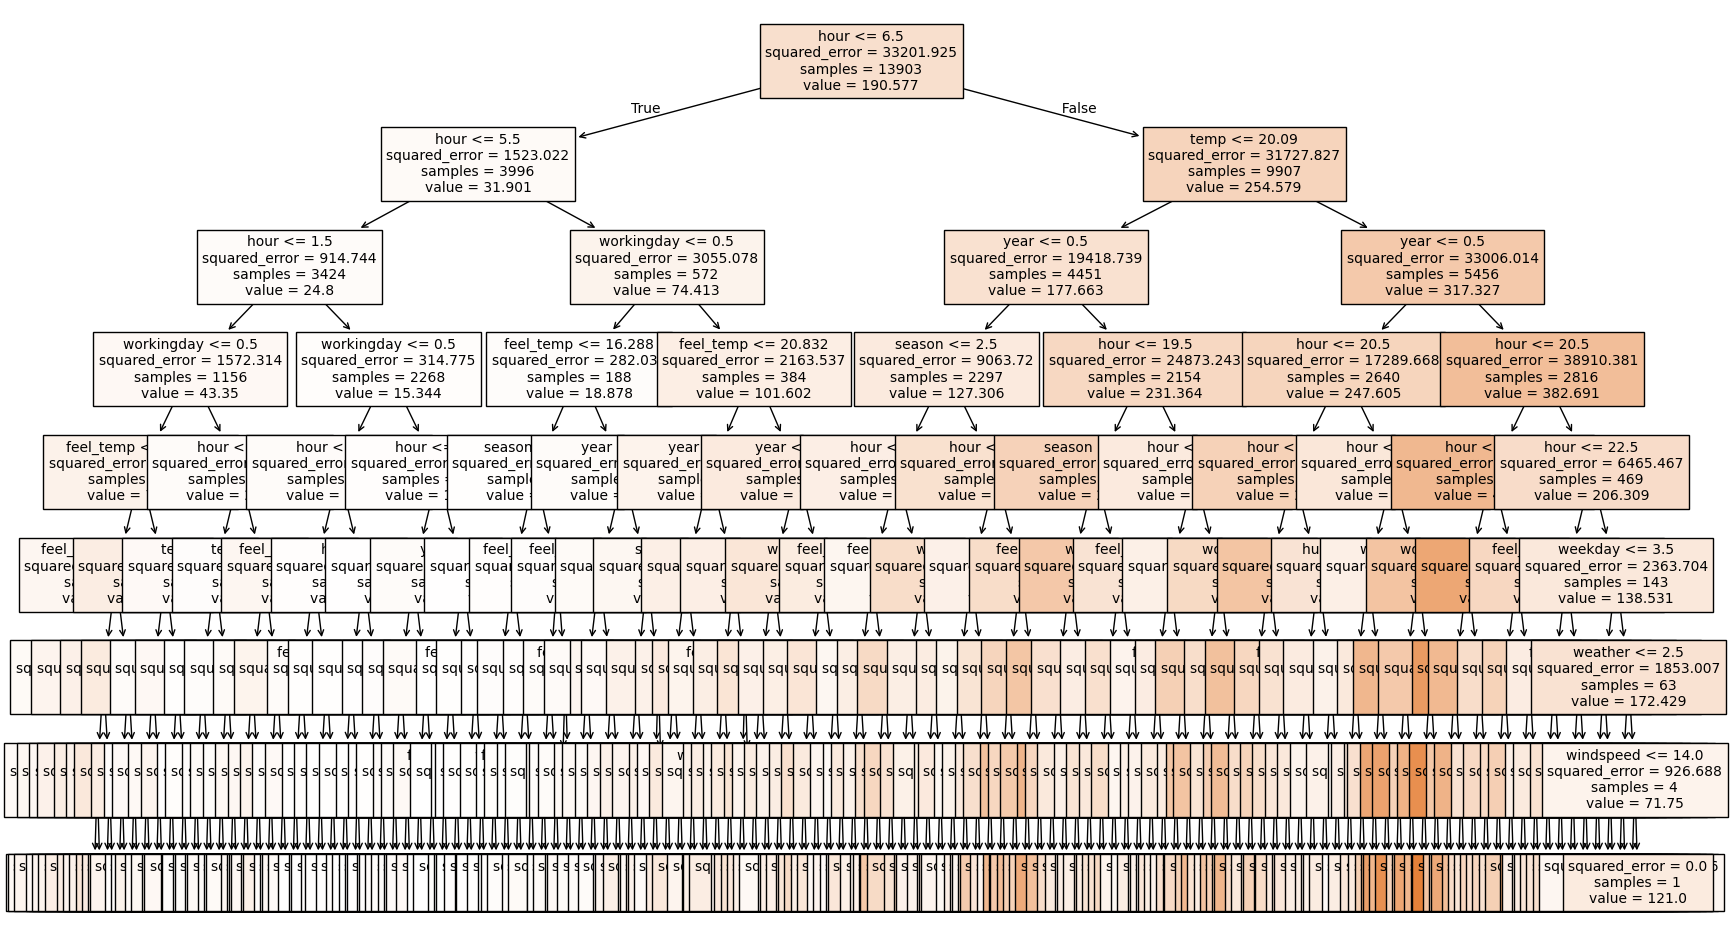

In [34]:
model = DecisionTreeRegressor(max_depth=8)
model.fit(X_train, y_train);
print("Nodes in decision tree:", model.tree_.node_count)
plt.figure(figsize=(20,12))
plot_tree(model, filled=True, feature_names=features, fontsize=10)
plt.show()

max_depth=n does NOT mean n splits: It means the longest path from root to leaf is n edges:

depth 0 → root

depth 1

depth 2

...

depth n → bottom decision nodes

In [35]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train);

In [36]:
model.tree_.node_count

26393

In [37]:
plt.figure(figsize=(20,20))
plot_tree(model, filled=True, feature_names=features)
#plt.show()
plt.savefig("large_tree.pdf", format="pdf")

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7e66d63dcd60> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7e66d639eb60> (for post_execute):


KeyboardInterrupt: 

# Feature importance

## Diabetes risk data

In [38]:
import kagglehub
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")
df = pd.read_csv(f"{path}/diabetes_prediction_dataset.csv")
df.head()

Using Colab cache for faster access to the 'diabetes-prediction-dataset' dataset.


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [39]:
mapping = {"Female": 0, "Male": 1}
df["gender"] = df["gender"].map(mapping)
print("gender:", mapping)
le = LabelEncoder()
df["smoking_history"] = le.fit_transform(df["smoking_history"])
print("smoking history:", [list(enumerate(le.classes_))])

X = df.drop(columns=["diabetes"])
features = X.columns
y = df["diabetes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

gender: {'Female': 0, 'Male': 1}
smoking history: [[(0, 'No Info'), (1, 'current'), (2, 'ever'), (3, 'former'), (4, 'never'), (5, 'not current')]]


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
75220,1.0,73.0,0,0,3,24.77,3.5,80
48955,1.0,80.0,0,0,4,24.60,5.7,145
44966,0.0,38.0,0,0,2,24.33,4.0,158
13568,0.0,26.0,0,0,5,18.87,5.0,100
92727,0.0,61.0,1,0,1,22.11,4.5,85
...,...,...,...,...,...,...,...,...
6265,1.0,49.0,0,0,4,32.98,5.7,80
54886,0.0,15.0,0,0,4,28.10,5.0,159
76820,1.0,42.0,0,0,4,26.14,5.8,85
860,0.0,37.0,0,0,4,24.96,6.2,158


In [40]:
def accuracy(true_values, predictions):
    return np.mean(true_values == predictions)

Model accuracy: 0.97215


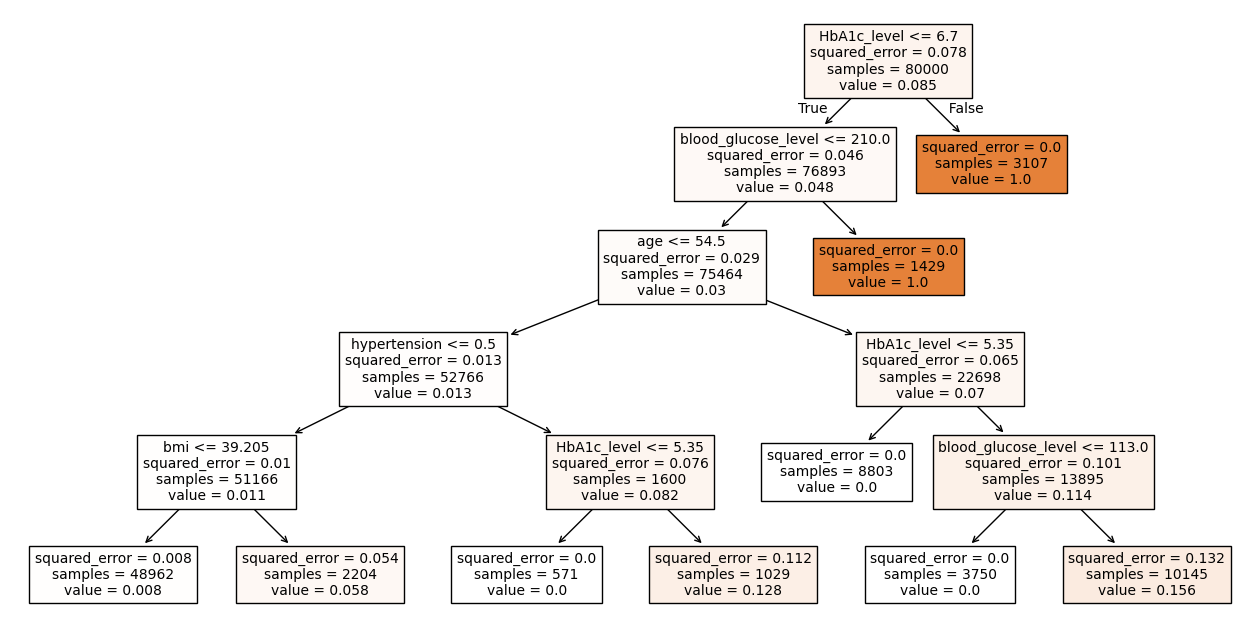

In [41]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)
print("Model accuracy:", accuracy(y_test, model.predict(X_test).round()))
model.tree_.node_count
plt.figure(figsize=(16,8))
plot_tree(model, filled=True, feature_names=features, fontsize=10)
plt.show()

1.0


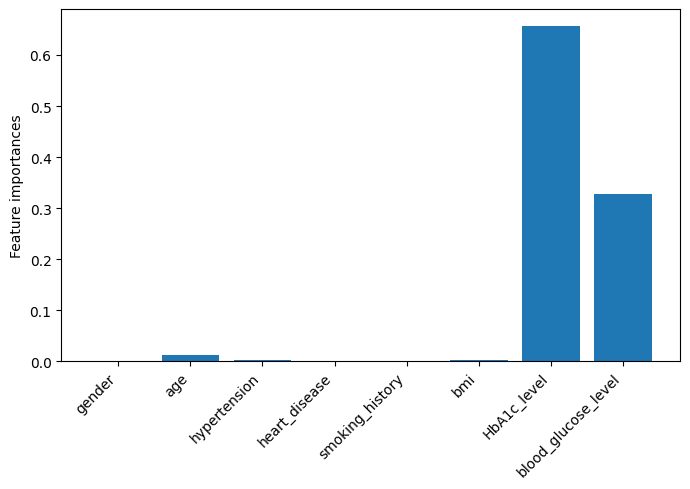

In [42]:
importances = model.feature_importances_
print(sum(importances))

x_pos = np.arange(len(features))
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(x_pos, importances)
ax.set_xticks(x_pos)
ax.set_xticklabels(features, rotation=45, ha="right")
ax.set_ylabel("Feature importances")
plt.tight_layout()
plt.show()


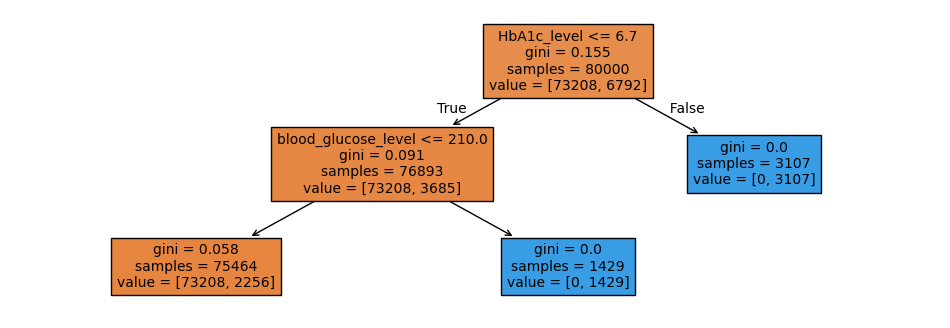

Model accuracy: 0.97215


In [ ]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_train, y_train)
model.tree_.node_count
plt.figure(figsize=(12,4))
plot_tree(model, filled=True, feature_names=features, fontsize=10)
plt.show()
print("Model accuracy:", accuracy(y_test, model.predict(X_test).round()))